<div class="alert alert-block alert-success">
<b>Group Work Project Submission #1</b><br> MScFE 620: Derivative Pricing. GROUP #332</div>

***
**<font size=6 color=blue>Derivatives - Options</font>**
***

<font size=5> **Step 1:**</font>

# Questions 1 to 4
***

>_1. Does put-call parity apply for European options? Why or why not?_

>> Yes. Put call parity applies to European options. We demonstrate its validity below with prices obtained for put and call using Black Scholes model.

***
> _2. Rewrite put-call parity to solve for the call in terms of everything else._
>> Equation for put-call parity to solve for call option in terms of everything else is as below:
>>

$$c = S_0 + p - K e^{-rt}$$


***
>_3. Rewrite put-call parity to solve for the put in terms of everything else._
>> Equation for put-call parity to solve for put option in terms of everything else is as below:
>>

$$p = c + K e^{-rt} - S_0$$


***
> _4. Does put-call parity apply for American options? Why or why not?_
>> No. Put call parity does not apply to American options due to the feature of early exercise.

***
We are given the information below: \
Underlying/Stock price, S=100 \
Option Strike price, K=100 \
Risk-free rate, r=5% \
Volatility $\sigma$=20% \
Time to expiration t=3 months

***
<font size=5> **Setup and initializations**</font>

***


In [1]:
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import yfinance as yf
import seaborn as sns
from math import log, sqrt, exp
from scipy import stats

plt.style.use("seaborn")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.rcParams["figure.figsize"] = (10, 6)
warnings.simplefilter(action="ignore", category=FutureWarning)

***
<font size=5> **Common function implementations**</font>

Here below are implementations of functions used in this notebook elsewhere.

In [2]:
# ----------------------------------------------------#
# Draws plot for given series
# ----------------------------------------------------#
def draw_plot(series1, xLabel, yLabel, title, series2=None, labels=[]):
    fig, ax = plt.subplots()
    if len(labels) != 0:
        series1.plot(ax=ax, label=labels[0])
    else:
        series1.plot(ax=ax)
    if series2 is not None:
        ax2 = ax.twinx()
        if len(labels) == 2:
            series2.plot(ax=ax2, color="orange", alpha=0.6, label=labels[1])
        else:
            series2.plot(ax=ax2, color="orange", alpha=0.6)
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1 + h2, l1 + l2, loc=2)

    ax.set_xlabel(xLabel, fontsize=14)
    ax.set_ylabel(yLabel, fontsize=14)

    ax.set_title(title, fontsize=14)
    fig.tight_layout()
    plt.show()


# ----------------------------------------------------#
# Fetches stock's current price from Yahoo Finance
# ----------------------------------------------------#
def get_stock_price(symbol):
    tk = yf.Ticker(symbol)
    return tk.get_info()["currentPrice"]


# ----------------------------------------------------#
# Fetches option chain data from Yahoo Finance
# ----------------------------------------------------#
def get_options_chains(symbol):
    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt["expirationDate"] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options["expirationDate"] = pd.to_datetime(
        options["expirationDate"]
    ) + datetime.timedelta(days=1)
    options["dte"] = (
        options["expirationDate"] - datetime.datetime.today()
    ).dt.days / 365

    # Boolean column if the option is a CALL
    options["CALL"] = options["contractSymbol"].str[4:].apply(lambda x: "C" in x)

    options["PUT"] = options["contractSymbol"].str[4:].apply(lambda x: "P" in x)

    options[["bid", "ask", "strike"]] = options[["bid", "ask", "strike"]].apply(
        pd.to_numeric
    )
    options["mark"] = (
        options["bid"] + options["ask"]
    ) / 2  # Calculate the midpoint of the bid-ask

    # Drop unnecessary and meaningless columns
    options = options.drop(
        columns=["contractSize", "currency", "change", "percentChange", "lastTradeDate"]
    )

    return options


# ----------------------------------------------------#
# Implementation for Black Scholes model d1
# ----------------------------------------------------#
def bsm_d1(S, K, T, r, σ):
    return (log(S / K) + (r + 0.5 * σ ** 2) * T) / (σ * sqrt(T))


# ----------------------------------------------------#
# Implementation for Black Scholes model d2
# ----------------------------------------------------#
def bsm_d2(S, K, T, r, σ):
    return (log(S / K) + (r - 0.5 * σ ** 2) * T) / (σ * sqrt(T))


# ----------------------------------------------------#
# Implementation for Black Scholes model call value
# ----------------------------------------------------#
def bsm_call_value(S, K, T, r, σ):
    S = float(S)
    d1 = bsm_d1(S, K, T, r, σ)
    d2 = bsm_d2(S, K, T, r, σ)
    value = S * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(
        d2, 0.0, 1.0
    )
    return value


# ----------------------------------------------------#
# Implementation for Black Scholes model put value
# ----------------------------------------------------#
def bsm_put_value(S, K, T, r, σ):
    S = float(S)
    d1 = bsm_d1(S, K, T, r, σ)
    d2 = bsm_d2(S, K, T, r, σ)
    value = K * exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0) - S * stats.norm.cdf(
        -d1, 0.0, 1.0
    )
    return value


# ----------------------------------------------------#
# Implementation for Black Scholes model call delta value
# ----------------------------------------------------#
def bsm_call_delta(S, K, T, r, σ):
    d1 = bsm_d1(S, K, T, r, σ)
    δ = stats.norm.cdf(d1)
    return δ


# ----------------------------------------------------#
# Implementation for Black Scholes model put delta value
# ----------------------------------------------------#
def bsm_put_delta(S, K, T, r, σ):
    d1 = bsm_d1(S, K, T, r, σ)
    δ = -1 * stats.norm.cdf(-d1)
    return δ


# ----------------------------------------------------#
# Implementation for Black Scholes model call gamma value
# ----------------------------------------------------#
def bsm_gamma(S, K, T, r, σ):
    d1 = bsm_d1(S, K, T, r, σ)
    γ = stats.norm.pdf(d1, 0.0, 1.0) / (S * σ * sqrt(T))
    return γ


# ----------------------------------------------------#
# Implementation for Black Scholes model vega value
# ----------------------------------------------------#
def bsm_vega(S, K, T, r, σ):
    S = float(S)
    d1 = bsm_d1(S, K, T, r, σ)
    vega = S * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega


# ----------------------------------------------------#
# Implementation for Black Scholes model call option
# implied vol
# ----------------------------------------------------#
def bsm_call_imp_vol(S, K, T, r, C, σ, it=100):

    for i in range(it):
        σ -= (bsm_call_value(S, K, T, r, σ) - C) / bsm_vega(S, K, T, r, σ)
    return σ


# ----------------------------------------------------#
# Implementation for Black Scholes model put option
# implied vol
# ----------------------------------------------------#
def bsm_put_imp_vol(S, K, T, r, P, σ, it=100):

    for i in range(it):
        σ -= (bsm_put_value(S, K, T, r, σ) - P) / bsm_vega(S, K, T, r, σ)
    return σ


# ----------------------------------------------------#
# Implementation for Binomial tree model for option
# Returns option value
# ----------------------------------------------------#
def binomial_tree_option_value(S, K, T, r, σ, amer_euro, call_put, N=1000):
    return round(binomial_tree(S, K, T, r, σ, amer_euro, call_put, N)[0], 2)


# ----------------------------------------------------#
# Implementation for Binomial tree model for option
# Returns payoff nodes
# ----------------------------------------------------#
def binomial_tree_O(S, K, T, r, σ, amer_euro, call_put, N=1000):
    return binomial_tree(S, K, T, r, σ, amer_euro, call_put, N)[1]


# ----------------------------------------------------#
# Implementation for Binomial tree model for option
# Returns underlying value nodes
# ----------------------------------------------------#
def binomial_tree_S(S, K, T, r, σ, amer_euro, call_put, N=1000):
    return binomial_tree(S, K, T, r, σ, amer_euro, call_put, N)[2]


# ----------------------------------------------------#
# Implementation for Binomial tree model for option
# Returns delta value nodes
# ----------------------------------------------------#
def binomial_tree_δ(S, K, T, r, σ, amer_euro, call_put, N=1000):
    return round(binomial_tree(S, K, T, r, σ, amer_euro, call_put, N)[3][0, 0], 4)


# ----------------------------------------------------#
# Implementation for Binomial tree model for option
# Returns gamma value
# ----------------------------------------------------#
def binomial_tree_γ(S, K, T, r, σ, amer_euro, call_put, N=1000):
    return round(binomial_tree(S, K, T, r, σ, amer_euro, call_put, N)[4], 4)


# ----------------------------------------------------#
# Implementation for Binomial tree model for option
# ----------------------------------------------------#
def binomial_tree(S0, K, T, r, σ, amer_euro, call_put, N=1000):
    dt = T / N  # Define time-step
    u = np.exp(σ * np.sqrt(dt))  # Define u
    d = np.exp(-σ * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probabilities (probs)
    O = np.zeros([N + 1, N + 1])  # option price
    S = np.zeros([N + 1, N + 1])  # Underlying price
    δ = np.zeros([N, N])  # delta

    S[0, 0] = S0  # Initialize the root
    for column in range(0, N + 1):
        for row in range(
            column, N
        ):  # Keep going diagonally starting from previous column
            S[row + 1, column] = S[row, column] * d  # Assign down move in matrix cell
            S[row + 1, column + 1] = S[row, column] * u  # Assign up move in matrix cell
        # Calculate call option at terminal values for underlying
        if call_put == "c" or call_put == "C":
            O[N, column] = max(S[N, column] - K, 0)
        else:
            O[N, column] = max(K - S[N, column], 0)
    # Backward induction for call option pricing
    for row in range(N - 1, -1, -1):
        for column in range(row, -1, -1):
            O[row, column] = np.exp(-r * dt) * (
                p * O[row + 1, column + 1] + (1 - p) * O[row + 1, column]
            )
            # Handle American option here
            if amer_euro == "a" or amer_euro == "A":
                if call_put == "c" or call_put == "C":
                    O[row, column] = max(O[row, column], S[row, column] - K)
                else:
                    O[row, column] = max(O[row, column], K - S[row, column])
            δ[row, column] = (O[row + 1, column + 1] - O[row + 1, column]) / (
                S[row + 1, column + 1] - S[row + 1, column]
            )

    # Calculate gamma
    γ = (δ[1, 1] - δ[1, 0]) / (S[1, 1] - S[1, 0])
    return O[0, 0], O, S, δ, γ

***
# Questions 5 to 7
***

>Set given variables globally here. These variables will be shared for questions below:

In [3]:
MONTHS_IN_YEAR = 12
S0 = 100  # Underlying price
K = 100  # Option Strike
r = 0.05  # Risk-free rate
σ = 0.20  # Volatility
t = 3 / MONTHS_IN_YEAR  # Time to option expiration

***
>_5. Price an ATM European call and put using Black-Scholes._

>Call option using BSM:

In [4]:
call_bsm_value = bsm_call_value(S0, K, t, r, σ)
print(f"Call option value using Black-Scholes is: ${round(call_bsm_value,2)}")

Call option value using Black-Scholes is: $4.61


>Put option using BSM:

In [5]:
put_bsm_value = bsm_put_value(S0, K, t, r, σ)
print(f"Put option value using Black-Scholes is: ${round(put_bsm_value,2)}")

Put option value using Black-Scholes is: $3.37


***
>_6. Compute the Greek Delta for the European call and European put. How do they compare?_

>>Delta for call options is position while for put options is negative.

> Delta for Call option using BSM:

In [6]:
call_bsm_delta = bsm_call_delta(S0, K, t, r, σ)
print(f"Call option delta using Black-Scholes is: {round(call_bsm_delta,4)}")

Call option delta using Black-Scholes is: 0.5695


>Delta for Put option using BSM:

In [7]:
put_bsm_delta = bsm_put_delta(S0, K, t, r, σ)
print(f"Put option delta using Black-Scholes is: {round(put_bsm_delta,4)}")

Put option delta using Black-Scholes is: -0.4305


***
>_7. Compute the Greek Gamma for the European call and European put. How do they compare?_

>>Gamma for both call and put European options is the same.

> Gamma for Call and Put option using BSM:

In [8]:
call_put_bsm_gamma = bsm_gamma(S0, K, t, r, σ)
print(
    f"Call and Put option gamma using Black-Scholes is: {round(call_put_bsm_gamma,4)}"
)

Call and Put option gamma using Black-Scholes is: 0.0393


*** 
# Questions 8 to 10
***

>_8. Price an ATM American call and put using a binomial tree._

>American call option using binomial tree:

In [9]:
american_or_european = "A"
call_or_put = "C"
price = binomial_tree_option_value(S0, K, t, r, σ, american_or_european, call_or_put)
print(f"Call option value using binomial tree is: ${price}")

Call option value using binomial tree is: $4.61


>American put option using binomial tree:

In [10]:
american_or_european = "A"
call_or_put = "P"
price = binomial_tree_option_value(S0, K, t, r, σ, american_or_european, call_or_put)
print(f"Put option value using binomial tree is: ${price}")

Put option value using binomial tree is: $3.48


***
>_9. Compute the Greek delta for the American call and American put. How do they compare?_

>>Delta for call options is positive while for put options is negative.

>American call option delta using binomial tree:

In [11]:
american_or_european = 'A'
call_or_put = 'C'
δ = binomial_tree_δ(S0, K, t, r, σ, american_or_european, call_or_put)
print(f"Call option delta using binomial tree is: {δ}")

Call option delta using binomial tree is: 0.5694


>American put option delta using binomial tree:

In [12]:
american_or_european = 'A'
call_or_put = 'P'
δ = binomial_tree_δ(S0, K, t, r, σ, american_or_european, call_or_put)
print(f"Put option delta using binomial tree is: {δ}")

Put option delta using binomial tree is: -0.4495


***
>_10. Compute the Greek gamma for the American call and American put. How do they compare?_
>> We observe gamma for both call and put to be positive but a relatively small number.

>American call option gamma using binomial tree:

In [13]:
american_or_european = "A"
call_or_put = "C"
γ = binomial_tree_γ(S0, K, t, r, σ, american_or_european, call_or_put)
print(f"Call option gamma using binomial tree is: {γ}")

Call option gamma using binomial tree is: 0.0393


>American put option delta using binomial tree:

In [14]:
american_or_european = "A"
call_or_put = "P"
γ = binomial_tree_γ(S0, K, t, r, σ, american_or_european, call_or_put)
print(f"put option gamma using binomial tree is: {γ}")

put option gamma using binomial tree is: 0.0423


*** 
# Questions 11 to 14
***

>_11. If the team answered Question 1 as “Yes”, then show that the European call and put satisfy put-call parity._

Put call parity equation is:

$$c + K e^{-rt} = S_0 + p$$


In [15]:
c = bsm_call_value(S0, K, t, r, σ)
p = bsm_put_value(S0, K, t, r, σ)

print(
    f"Left-hand side for put call parity for European option is: ${round(c + K * exp(-r*t),2)}."
)
print(
    f"Right-hand side for put call parity for European option is: ${round((S0 + p),2)}."
)
print(
    f"Put call parity for European option holds: {round(c + K * exp(-r*t),2) == round(S0 + p,2)}."
)

Left-hand side for put call parity for European option is: $103.37.
Right-hand side for put call parity for European option is: $103.37.
Put call parity for European option holds: True.


***
>_12. If the team answered Question 4 as “Yes”, then show that the American call and put satisfy put-call parity._

>>Put call parity does not hold for American options due to early exercise feature of these type of options. 

>>Put call parity equation is:

$$c + K e^{-rt} = S_0 + p$$


In [16]:
american_or_european = "A"
call = "C"
c = binomial_tree_option_value(S0, K, t, r, σ, american_or_european, call)
put = "P"
p = binomial_tree_option_value(S0, K, t, r, σ, american_or_european, put)

print(
    f"Left-hand side for put call parity for American option is: ${round(c + K * exp(-r*t),2)}."
)
print(
    f"Right-hand side for put call parity for American option is: ${round((S0 + p),4)}."
)
print(
    f"Put call parity for American option holds: {round(c + K * exp(-r*t),2) == round(S0 + p,2)}."
)

Left-hand side for put call parity for American option is: $103.37.
Right-hand side for put call parity for American option is: $103.48.
Put call parity for American option holds: False.


***
>_13. Confirm that the European call is less than or equal to the American call. Show the difference if any._

In [17]:
# Get call value for eurpean call option using Black-Scholes model
european_option_value = round(bsm_call_value(S0, K, t, r, σ), 2)
# Get call value for american call option using Binomial tree
american_or_european = "A"
call = "C"
american_option_value = binomial_tree_option_value(
    S0, K, t, r, σ, american_or_european, call
)
print(f"Value of European call option is: ${european_option_value}")
print(f"Value of American call option is: ${american_option_value}")
print(
    f"Value of European call option is equal to American call:\
    {european_option_value == american_option_value}"
)
print(
    f"Difference between prices of two options is: ${round(american_option_value - european_option_value,2)}"
)

Value of European call option is: $4.61
Value of American call option is: $4.61
Value of European call option is equal to American call:    True
Difference between prices of two options is: $0.0


***
>_14. Confirm that the European put is less than or equal to the American put. Show the difference if any._

In [18]:
# Get call value for eurpean put option using Black-Scholes model
european_option_value = round(bsm_put_value(S0, K, t, r, σ), 2)
# Get call value for american put option using Binomial tree
american_or_european = "A"
call = "P"
american_option_value = binomial_tree_option_value(
    S0, K, t, r, σ, american_or_european, call
)
print(f"Value of European put option is: ${european_option_value}")
print(f"Value of American put option is: ${american_option_value}")
print(
    f"Value of European put option is less than American put: {european_option_value < american_option_value}"
)
print(
    f"Difference between prices of two options is: ${american_option_value - european_option_value:.2f}"
)

Value of European put option is: $3.37
Value of American put option is: $3.48
Value of European put option is less than American put: True
Difference between prices of two options is: $0.11


***
<font size=5> **Step 2:**</font>

_NOTE: For questions 15 to 22, keep the stock price fixed at 100._

# Questions 15 to 18
***

>_15. Use a strike level so that calls are ITM and puts are OTM._
>>_a) Price an American call and put using a binomial tree._ \
>>_b) Compute the Greek delta for the American call and American put. How do they compare?_ \
>>_c) Compute the Greek gamma for the American call and American put. How do they compare?_ 

Set strike prices for ITM (in-the-money) call & OTM (out-of-the-money) put options:

In [19]:
S0 = 100
K_call_itm = K_put_otm = 90

***
**Option prices:**

Price ITM American call option using binomial tree:

In [20]:
american_or_european = "A"
call_or_put = "C"
price = binomial_tree_option_value(
    S0, K_call_itm, t, r, σ, american_or_european, call_or_put
)
print(f"Call option value using binomial tree is: ${price}")

Call option value using binomial tree is: $11.67


Price OTM American put option using binomial tree:

In [21]:
american_or_european = "A"
call_or_put = "P"
price = binomial_tree_option_value(
    S0, K_put_otm, t, r, σ, american_or_european, call_or_put
)
print(f"Put option value using binomial tree is: ${price}")

Put option value using binomial tree is: $0.56


***
**Option delta:**

> We observe delta for ITM call option is positive while OTM put option has negative delta. 

American call option delta using binomial tree:

In [22]:
american_or_european = 'A'
call_or_put = 'C'
δ = binomial_tree_δ(S0, K_call_itm, t, r, σ, american_or_european, call_or_put)
print(f"Call option delta using binomial tree is: {δ}")

Call option delta using binomial tree is: 0.8904


American put option delta using binomial tree:

In [23]:
american_or_european = 'A'
call_or_put = 'P'
δ = binomial_tree_δ(S0, K_put_otm, t, r, σ, american_or_european, call_or_put)
print(f"Put option delta using binomial tree is: {δ}")

Put option delta using binomial tree is: -0.1122


***
**Option gamma:**

> We observe positive gamma for both ITM call and OTM put options.

American call option gamma using binomial tree:

In [24]:
american_or_european = "A"
call_or_put = "C"
γ = binomial_tree_γ(S0, K_call_itm, t, r, σ, american_or_european, call_or_put)
print(f"Call option gamma using binomial tree is: {γ}")

Call option gamma using binomial tree is: 0.0188


American put option gamma using binomial tree:

In [25]:
american_or_european = "A"
call_or_put = "P"
γ = binomial_tree_γ(S0, K_put_otm, t, r, σ, american_or_european, call_or_put)
print(f"Put option gamma using binomial tree is: {γ}")

Put option gamma using binomial tree is: 0.0193


***
>16. Use another strike level so that calls are deep ITM and puts are deep OTM.
>>_a) Price an American call and put using a binomial tree._ \
>>_b) Compute the Greek delta for the American call and American put. How do they compare?_ \
>>_c) Compute the Greek gamma for the American call and American put. How do they compare?_ 

Set strike prices for deep ITM (in-the-money) calls & deep OTM (out-of-the-money) put options:

In [26]:
S0 = 100
K_call_deep_itm = K_put_deep_otm = 80

***
**Option prices:**

Price deep ITM American call option using binomial tree:

In [27]:
american_or_european = "A"
call_or_put = "C"
price = binomial_tree_option_value(
    S0, K_call_deep_itm, t, r, σ, american_or_european, call_or_put
)
print(f"Call option value using binomial tree is: ${price}")

Call option value using binomial tree is: $21.02


Price deep OTM American put option using binomial tree:

In [28]:
american_or_european = "A"
call_or_put = "P"
price = binomial_tree_option_value(
    S0, K_put_deep_otm, t, r, σ, american_or_european, call_or_put
)
print(f"Put option value using binomial tree is: ${price}")

Put option value using binomial tree is: $0.03


***
**Option delta:**
> We observe delta for deep ITM call option to be approaching close to 1 and that off deep OTM put option to be getting close to 0.

American deep ITM call option delta using binomial tree:

In [29]:
american_or_european = 'A'
call_or_put = 'C'
δ = binomial_tree_δ(S0, K_call_deep_itm, t, r, σ, american_or_european, call_or_put)
print(f"Call option delta using binomial tree is: {δ}")

Call option delta using binomial tree is: 0.992


American deep OTM put option delta using binomial tree:

In [30]:
american_or_european = 'A'
call_or_put = 'P'
δ = binomial_tree_δ(S0, K_put_deep_otm, t, r, σ, american_or_european, call_or_put)
print(f"Put option delta using binomial tree is: {δ}")

Put option delta using binomial tree is: -0.0081


***
**Option gamma:**
> We observe gamma for both deep ITM call and deep OTM put option to be very small albeit positive.

American deep ITM call option gamma using binomial tree:

In [31]:
american_or_european = "A"
call_or_put = "C"
γ = binomial_tree_γ(S0, K_call_deep_itm, t, r, σ, american_or_european, call_or_put)
print(f"Call option gamma using binomial tree is: {γ}")

Call option gamma using binomial tree is: 0.0022


American deep OTM put option gamma using binomial tree:

In [32]:
american_or_european = "A"
call_or_put = "P"
γ = binomial_tree_γ(S0, K_put_deep_otm, t, r, σ, american_or_european, call_or_put)
print(f"Put option gamma using binomial tree is: {γ}")

Put option gamma using binomial tree is: 0.0022


>_17. Use a strike level so that calls are OTM and puts are ITM._
>>_a) Price an American call and put using a binomial tree._ \
>>_b) Compute the Greek delta for the American call and American put. How do they compare?_ \
>>_c) Compute the Greek gamma for the American call and American put. How do they compare?_ 

Set strike prices for OTM (out-of-the-money) calls & ITM (in-the-money) put options:

In [33]:
S0 = 100
K_call_otm = K_put_itm = 110

***
**Option prices:**

Price OTM American call option using binomial tree:

In [34]:
american_or_european = "A"
call_or_put = "C"
price = binomial_tree_option_value(
    S0, K_call_otm, t, r, σ, american_or_european, call_or_put
)
print(f"Call option value using binomial tree is: ${price}")

Call option value using binomial tree is: $1.19


Price ITM American put option using binomial tree:

In [35]:
american_or_european = "A"
call_or_put = "P"
price = binomial_tree_option_value(
    S0, K_put_itm, t, r, σ, american_or_european, call_or_put
)
print(f"Put option value using binomial tree is: ${price}")

Put option value using binomial tree is: $10.33


***
**Option delta:**
>We observe delta for OTM call options to be positive and ITM put options to be negative.

American OTM call option delta using binomial tree:

In [36]:
american_or_european = 'A'
call_or_put = 'C'
δ = binomial_tree_δ(S0, K_call_otm, t, r, σ, american_or_european, call_or_put)
print(f"Call option delta using binomial tree is: {δ}")

Call option delta using binomial tree is: 0.2181


American ITM put option delta using binomial tree:

In [37]:
american_or_european = 'A'
call_or_put = 'P'
δ = binomial_tree_δ(S0, K_put_itm, t, r, σ, american_or_european, call_or_put)
print(f"Put option delta using binomial tree is: {δ}")

Put option delta using binomial tree is: -0.8485


***
**Option gamma:**
> We observe positive gamma for both OTM call and ITM put options.

American OTM call option gamma using binomial tree:

In [38]:
american_or_european = "A"
call_or_put = "C"
γ = binomial_tree_γ(S0, K_call_otm, t, r, σ, american_or_european, call_or_put)
print(f"Call option gamma using binomial tree is: {γ}")

Call option gamma using binomial tree is: 0.0295


American ITM put option gamma using binomial tree:

In [39]:
american_or_european = "A"
call_or_put = "P"
γ = binomial_tree_γ(S0, K_put_itm, t, r, σ, american_or_european, call_or_put)
print(f"Put option gamma using binomial tree is: {γ}")

Put option gamma using binomial tree is: 0.0369


***
>_18. Use another strike level so that calls are deep OTM and puts are deep OTM._
>>_a) Price an American call and put using a binomial tree._ \
>>_b) Compute the Greek delta for the American call and American put. How do they compare?_ \
>>_c) Compute the Greek gamma for the American call and American put. How do they compare?_ 

Set strike prices for deep OTM (out-of-the-money) calls & deep ITM (in-the-money) put options:

In [40]:
S0 = 100
K_call_deep_otm = 120
K_put_deep_otm = 80

***
**Option prices:**

Price deep OTM American call option using binomial tree:

In [41]:
american_or_european = "A"
call_or_put = "C"
price = binomial_tree_option_value(
    S0, K_call_deep_otm, t, r, σ, american_or_european, call_or_put
)
print(f"Call option value using binomial tree is: ${price}")

Call option value using binomial tree is: $0.2


Price deep OTM American put option using binomial tree

In [42]:
american_or_european = "A"
call_or_put = "P"
price = binomial_tree_option_value(
    S0, K_put_deep_otm, t, r, σ, american_or_european, call_or_put
)
print(f"Put option value using binomial tree is: ${price}")

Put option value using binomial tree is: $0.03


***
**Option delta:**
>We observe delta for deep OTM call option to be near zero but small positive. The delta for deep OTM put option is also close to 0 and small negative.

Delta for deep OTM American call option using binomial tree: 

In [43]:
american_or_european = "A"
call_or_put = "C"
δ = binomial_tree_δ(S0, K_call_deep_otm, t, r, σ, american_or_european, call_or_put)
print(f"Call option delta using binomial tree is: {δ}")

Call option delta using binomial tree is: 0.0496


Delta for deep OTM American put option using binomial tree:

In [44]:
american_or_european = "A"
call_or_put = "P"
δ = binomial_tree_δ(S0, K_put_deep_otm, t, r, σ, american_or_european, call_or_put)
print(f"Put option delta using binomial tree is: {δ}")

Put option delta using binomial tree is: -0.0081


***
**Option gamma:**
>We observe gamma for both deep OTM call and deep OTM put options to be near zero but stay positive.

Gamma for deep OTM American call option using binomial tree: 

In [45]:
american_or_european = "A"
call_or_put = "C"
γ = binomial_tree_γ(S0, K_call_deep_otm, t, r, σ, american_or_european, call_or_put)
print(f"Call option gamma using binomial tree is: {γ}")

Call option gamma using binomial tree is: 0.0102


Gamma for deep OTM American put option using binomial tree:

In [46]:
american_or_european = "A"
call_or_put = "P"
γ = binomial_tree_γ(S0, K_put_deep_otm, t, r, σ, american_or_european, call_or_put)
print(f"Put option gamma using binomial tree is: {γ}")

Put option gamma using binomial tree is: 0.0022


*** 
# Questions 23 to 28
***

>_23. Graph #1. Graph European call prices and put prices versus stock price._

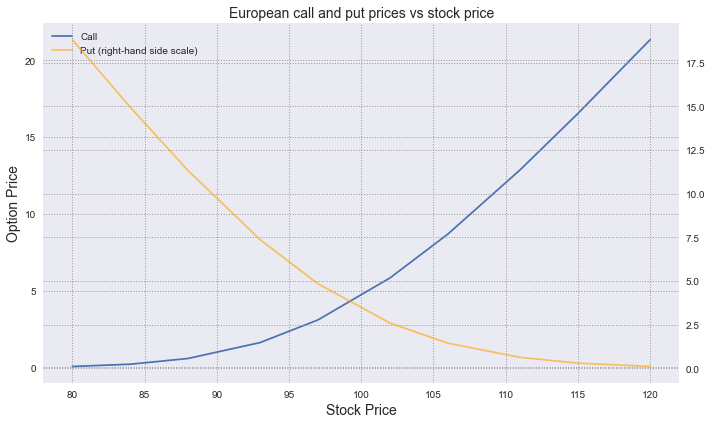

In [47]:
stock_prices = np.floor(np.linspace(80, 120, 10))
call_prices = pd.Series(index=stock_prices, dtype=float)
put_prices = pd.Series(index=stock_prices, dtype=float)
for i, stock_price in enumerate(stock_prices):
    call_prices.iloc[i] = bsm_call_value(stock_price, K, t, r, σ)
    put_prices.iloc[i] = bsm_put_value(stock_price, K, t, r, σ)
draw_plot(
    call_prices,
    "Stock Price",
    "Option Price",
    "European call and put prices vs stock price",
    put_prices,
    labels=["Call", "Put (right-hand side scale)"],
)

>_24. Graph #2. Graph American call prices and put prices versus strike._

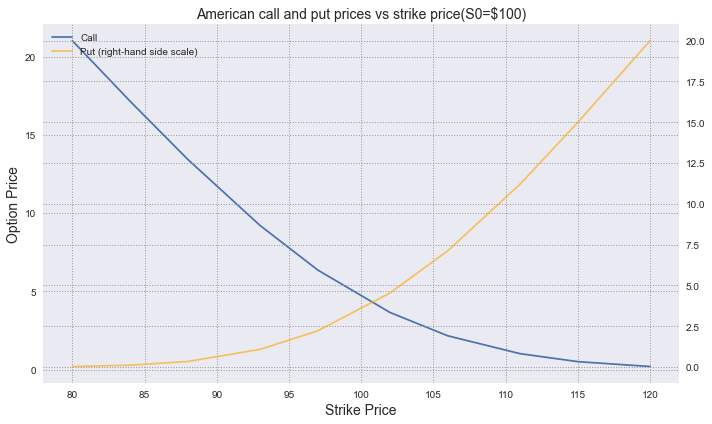

In [48]:
strike_prices = np.floor(np.linspace(80, 120, 10))
call_prices = pd.Series(index=strike_prices, dtype=float)
put_prices = pd.Series(index=strike_prices, dtype=float)
for i, strike_price in enumerate(strike_prices):
    call_prices.iloc[i] = binomial_tree_option_value(
        S0, strike_price, t, r, σ, "A", "C", N=200
    )
    put_prices.iloc[i] = binomial_tree_option_value(
        S0, strike_price, t, r, σ, "A", "P", N=200
    )
draw_plot(
    call_prices,
    "Strike Price",
    "Option Price",
    "American call and put prices vs strike price(S0=$100)",
    put_prices,
    labels=["Call", "Put (right-hand side scale)"],
)

>_25. Graph #3. Graph European and American call prices versus strike._

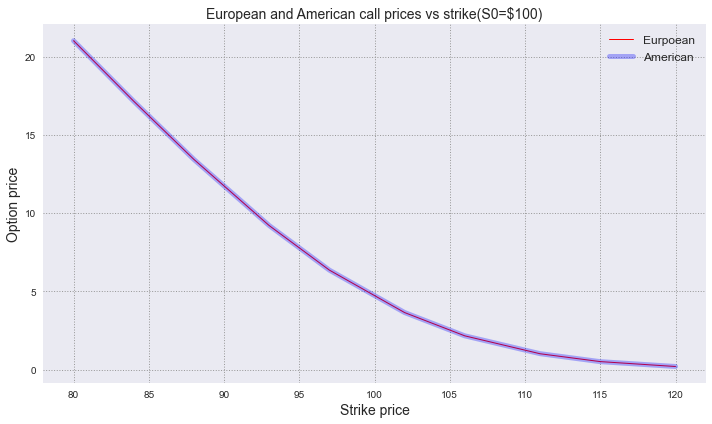

In [49]:
strike_prices = np.floor(np.linspace(80, 120, 10))
call_prices_eu = pd.Series(index=strike_prices, dtype=float)
call_prices_am = pd.Series(index=strike_prices, dtype=float)
for i, strike_price in enumerate(strike_prices):
    call_prices_eu.iloc[i] = bsm_call_value(S0, strike_price, t, r, σ)
    call_prices_am.iloc[i] = binomial_tree_option_value(
        S0, strike_price, t, r, σ, "A", "C", N=200
    )

fig, ax = plt.subplots()
call_prices_eu.plot(label=f"Eurpoean", ax=ax, linewidth=1, color="red", alpha=1)
call_prices_am.plot(label=f"American", ax=ax, linewidth=5, color="blue", alpha=0.3)
ax.legend(fontsize=12)
ax.set_title("European and American call prices vs strike(S0=$100)", fontsize=14)
ax.set_xlabel("Strike price", fontsize=14)
ax.set_ylabel("Option price", fontsize=14)

plt.tight_layout()
plt.show()

>_26. Graph #4. Graph European and American put prices versus strike._

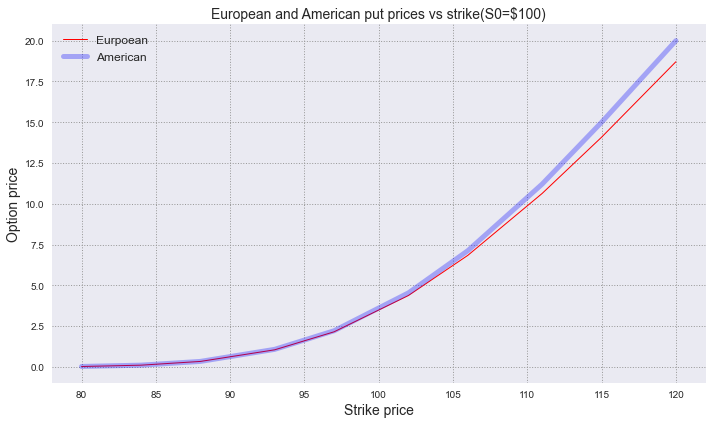

In [50]:
strike_prices = np.floor(np.linspace(80, 120, 10))
put_prices_eu = pd.Series(index=strike_prices, dtype=float)
put_prices_am = pd.Series(index=strike_prices, dtype=float)
for i, strike_price in enumerate(strike_prices):
    put_prices_eu.iloc[i] = bsm_put_value(S0, strike_price, t, r, σ)
    put_prices_am.iloc[i] = binomial_tree_option_value(
        S0, strike_price, t, r, σ, "A", "P", N=200
    )

fig, ax = plt.subplots()
put_prices_eu.plot(label=f"Eurpoean", ax=ax, linewidth=1, color="red", alpha=1)
put_prices_am.plot(label=f"American", ax=ax, linewidth=5, color="blue", alpha=0.3)
ax.legend(fontsize=12)
ax.set_title("European and American put prices vs strike(S0=$100)", fontsize=14)
ax.set_xlabel("Strike price", fontsize=14)
ax.set_ylabel("Option price", fontsize=14)

plt.tight_layout()
plt.show()

>_27. Graph #5. Graph European deltas versus strike._

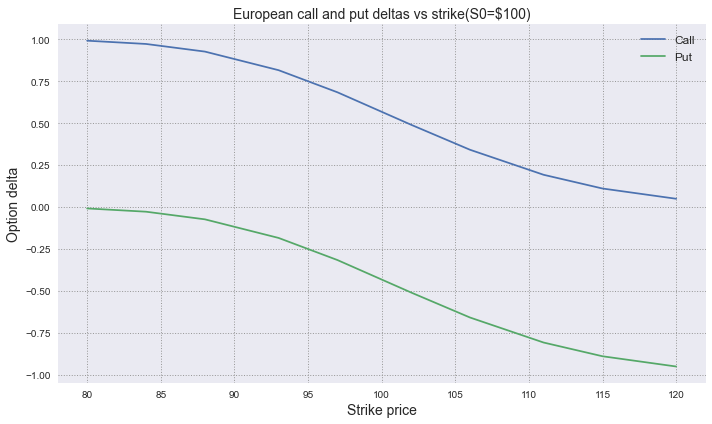

In [51]:
strike_prices = np.floor(np.linspace(80, 120, 10))
call_deltas = pd.Series(index=strike_prices, dtype=float)
put_deltas = pd.Series(index=strike_prices, dtype=float)

for i, strike_price in enumerate(strike_prices):
    call_deltas.iloc[i] = bsm_call_delta(S0, strike_price, t, r, σ)
    put_deltas.iloc[i] = bsm_put_delta(S0, strike_price, t, r, σ)

fig, ax = plt.subplots()
call_deltas.plot(label=f"Call", ax=ax)
put_deltas.plot(label=f"Put", ax=ax)
ax.legend(fontsize=12)
ax.set_title("European call and put deltas vs strike(S0=$100)", fontsize=14)
ax.set_xlabel("Strike price", fontsize=14)
ax.set_ylabel("Option delta", fontsize=14)

plt.tight_layout()
plt.show()

>_28. Graph #6. Graph European gammas versus strike._

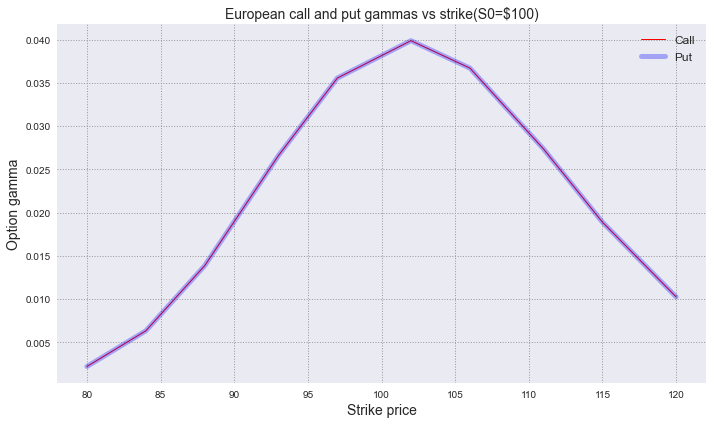

In [52]:
strike_prices = np.floor(np.linspace(80, 120, 10))
call_gammas = pd.Series(index=strike_prices, dtype=float)
put_gammas = pd.Series(index=strike_prices, dtype=float)

for i, strike_price in enumerate(strike_prices):
    call_gammas.iloc[i] = bsm_gamma(S0, strike_price, t, r, σ)
    put_gammas.iloc[i] = bsm_gamma(S0, strike_price, t, r, σ)

fig, ax = plt.subplots()
call_gammas.plot(label=f"Call", ax=ax, linewidth=1, color="red", alpha=1)
put_gammas.plot(label=f"Put", ax=ax, linewidth=5, color="blue", alpha=0.3)
ax.legend(fontsize=12)
ax.set_title("European call and put gammas vs strike(S0=$100)", fontsize=14)
ax.set_xlabel("Strike price", fontsize=14)
ax.set_ylabel("Option gamma", fontsize=14)

plt.tight_layout()
plt.show()

*** 
<font size=5> **Step 3:**</font>

# Questions 29 to 35
***

>_29. Pick a non-FANG stock for which you can get option data._

For this exercise, we obtained options chain data for TSLA stock from Yahoo finance.

In [53]:
STRIKE_DISTANCE = 5
STRIKE_THRESHOLD = STRIKE_DISTANCE * 3

UNDERLYING_SYMBOL = "TSLA"
option_chains = get_options_chains(UNDERLYING_SYMBOL)

underlying_price = get_stock_price(UNDERLYING_SYMBOL)
print(f"Current underlying price is ${underlying_price}")

# Create mask to remove option chains with nonuseful data
mask = option_chains["volume"] != None
mask &= option_chains["dte"] != 0
mask &= (
    option_chains["strike"]
    > (round(underlying_price / STRIKE_DISTANCE, 0) * STRIKE_DISTANCE)
    - STRIKE_THRESHOLD
)
mask &= (
    option_chains["strike"]
    < (round(underlying_price / STRIKE_DISTANCE, 0) * STRIKE_DISTANCE)
    + STRIKE_THRESHOLD
)

option_chains = option_chains[mask]

# Separate out call options
call_options = option_chains[option_chains["CALL"]]
# Separate out put options
put_options = option_chains[option_chains["PUT"]]

Current underlying price is $270.21


***
<font size=4>**Call options data**</font>

In [91]:
call_options

,contractSymbol,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,dte,CALL,PUT,mark
50,TSLA220909C00256670,256.67,15.45,15.90,16.35,352.0,281.0,0.608891,True,2022-09-10,0.013699,True,False,16.125
51,TSLA220909C00258330,258.33,14.35,14.60,15.10,297.0,342.0,0.604008,True,2022-09-10,0.013699,True,False,14.850
52,TSLA220909C00260000,260.00,13.25,13.35,13.80,1152.0,697.0,0.595707,True,2022-09-10,0.013699,True,False,13.575
53,TSLA220909C00261670,261.67,11.90,12.15,12.40,739.0,821.0,0.581181,True,2022-09-10,0.013699,True,False,12.275
54,TSLA220909C00263330,263.33,10.89,11.00,11.45,554.0,595.0,0.583989,True,2022-09-10,0.013699,True,False,11.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,TSLA240621C00270000,270.00,90.00,88.85,91.25,134.0,1037.0,0.641773,True,2024-06-22,1.797260,True,False,90.050
7161,TSLA240621C00273330,273.33,89.00,86.90,89.80,3.0,1118.0,0.637272,False,2024-06-22,1.797260,True,False,88.350
7162,TSLA240621C00276670,276.67,87.58,86.25,88.45,51.0,637.0,0.637974,False,2024-06-22,1.797260,True,False,87.350
7163,TSLA240621C00280000,280.00,86.00,85.10,86.90,70.0,787.0,0.635898,False,2024-06-22,1.797260,True,False,86.000


***
<font size=4>**Put options data**</font>

In [55]:
put_options

,contractSymbol,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,dte,CALL,PUT,mark
331,TSLA220909P00256670,256.67,2.40,2.29,2.36,1595.0,1251.0,0.581059,False,2022-09-10,0.013699,False,True,2.325
332,TSLA220909P00258330,258.33,2.69,2.64,2.77,2458.0,1959.0,0.577641,False,2022-09-10,0.013699,False,True,2.705
333,TSLA220909P00260000,260.00,3.10,3.05,3.15,18826.0,3924.0,0.570683,False,2022-09-10,0.013699,False,True,3.100
334,TSLA220909P00261670,261.67,3.50,3.50,3.70,2243.0,986.0,0.569096,False,2022-09-10,0.013699,False,True,3.600
335,TSLA220909P00263330,263.33,4.08,4.00,4.15,3104.0,1360.0,0.560673,False,2022-09-10,0.013699,False,True,4.075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7358,TSLA240621P00270000,270.00,74.09,72.65,73.90,2.0,534.0,0.518422,False,2024-06-22,1.797260,False,True,73.275
7359,TSLA240621P00273330,273.33,74.50,74.60,75.80,1.0,855.0,0.516942,True,2024-06-22,1.797260,False,True,75.200
7360,TSLA240621P00276670,276.67,77.60,76.05,77.70,4.0,870.0,0.513478,True,2024-06-22,1.797260,False,True,76.875
7361,TSLA240621P00280000,280.00,79.15,78.40,79.65,27.0,1189.0,0.513356,True,2024-06-22,1.797260,False,True,79.025


***
>_30. Select 5 strike levels for a call option: 2 ITM, 1 ATM, and 2 OTM._

In [89]:
START_STRIKE = 0
NUMBER_OF_STRIKES = 5

call_strike_count = call_options.groupby("strike")["expirationDate"].count()
call_option_strikes = pd.Series(dtype=float)
call_option_strikes = call_strike_count[
    call_strike_count >= call_strike_count.max() - 2
]
# Narrow it down to 5 select strikes for performance reasons
call_option_strikes = call_option_strikes.iloc[
    START_STRIKE : START_STRIKE + NUMBER_OF_STRIKES
]
call_option_strikes

strike
260.00    14
266.67    15
273.33    13
280.00    15
283.33    15
Name: expirationDate, dtype: int64

In [128]:
START_TENURE = 0
NO_OF_TENURES = 4

call_options_expirations = call_options["expirationDate"].unique()
# Narrow it down to top select expirations for performance reasons
call_options_expirations = call_options_expirations[
    START_TENURE : START_TENURE + NO_OF_TENURES
]
call_options_expirations

array(['2022-09-10T00:00:00.000000000', '2022-09-17T00:00:00.000000000',
       '2022-09-24T00:00:00.000000000', '2022-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [129]:
call_options_filtered = call_options[
    call_options["strike"].isin(call_option_strikes.index.values)
]
call_options_filtered = call_options_filtered[
    call_options_filtered["expirationDate"].isin(call_options_expirations)
]
call_options_filtered.tail(18)

,contractSymbol,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,dte,CALL,PUT,mark
56,TSLA220909C00266670,266.67,8.76,8.90,9.20,1236.0,4387.0,0.569829,True,2022-09-10,0.013699,True,False,9.050
60,TSLA220909C00273330,273.33,5.46,5.35,5.65,5165.0,1165.0,0.547612,False,2022-09-10,0.013699,True,False,5.500
64,TSLA220909C00280000,280.00,2.96,2.93,3.05,38063.0,3844.0,0.528813,False,2022-09-10,0.013699,True,False,2.990
66,TSLA220909C00283330,283.33,2.13,2.07,2.21,4575.0,1135.0,0.524175,False,2022-09-10,0.013699,True,False,2.140
702,TSLA220916C00260000,260.00,16.89,17.10,17.45,225.0,21062.0,0.597538,True,2022-09-17,0.032877,True,False,17.275
707,TSLA220916C00266670,266.67,12.75,12.90,13.30,736.0,46096.0,0.579167,True,2022-09-17,0.032877,True,False,13.100
713,TSLA220916C00273330,273.33,9.41,9.40,9.70,1092.0,7366.0,0.561772,False,2022-09-17,0.032877,True,False,9.550
718,TSLA220916C00280000,280.00,6.62,6.55,6.75,8323.0,6261.0,0.545415,False,2022-09-17,0.032877,True,False,6.650
720,TSLA220916C00283330,283.33,5.48,5.35,5.60,2157.0,18377.0,0.539189,False,2022-09-17,0.032877,True,False,5.475
1710,TSLA220923C00260000,260.00,20.01,19.45,20.70,70.0,751.0,0.597172,True,2022-09-24,0.052055,True,False,20.075


Plot the implied vols for visual check and interpretation:

***
>_31. Are these options European or American?_

>TSLA options are American options listed on US options exchange CBOE.

***
>_32. Using these strike levels, apply your code to price that option. Be sure to use the correct values of stock price, strike level, time to maturity, risk-free rate, and volatility._

As options chosen by us above are American options, we price call options using Binomial tree here below:

In [130]:
# Poor man's way to use risk-free rate structure with linear interpolation of current treasury yield rates
treasury_yields = np.linspace(0.0287, 0.0289, len(call_options_expirations))

call_options_filtered_strikes = call_options_filtered["strike"].unique()
call_options_filtered_expirations = call_options_filtered["expirationDate"].unique()
# Set index on strikes and expiration dates for further processing
call_options_filtered_by_strike_exp = call_options_filtered.set_index(
    ["strike", "expirationDate"]
)

american_or_european = "A"
call_or_put = "C"
call_tree_prices = []
for j, expiration in enumerate(call_options_filtered_expirations):
    tree_temp = []
    for i, strike in enumerate(call_options_filtered_strikes):
        try:
            option = call_options_filtered_by_strike_exp.loc[strike, expiration]
            tree_temp.append(
                binomial_tree_option_value(
                    underlying_price,
                    strike,
                    option["dte"],
                    treasury_yields[j],
                    option["impliedVolatility"],
                    american_or_european,
                    call_or_put,
                )
            )
        except KeyError:
            tree_temp.append(np.NaN)
    call_tree_prices.append(tree_temp)

Graph Option prices obtained using Binomial tree

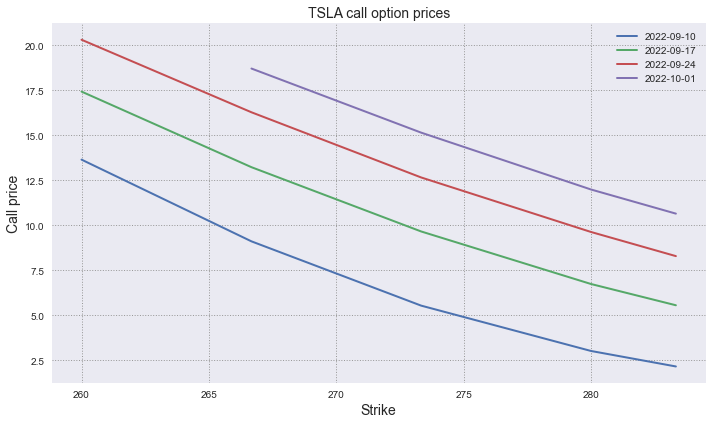

In [131]:
# option prices using binomial tree
call_prices_vols_stacked = np.vstack(call_tree_prices)

fig, ax = plt.subplots()
for i, call_tree_price in enumerate(call_tree_prices):
    plt.plot(
        call_options_filtered_strikes,
        np.array(call_tree_price),
        label=pd.to_datetime(call_options_expirations[i]).date(),
        linewidth = 2
    )

ax.set_xlabel("Strike", fontsize=14)
ax.set_ylabel("Call price", fontsize=14)

ax.set_title(f"{UNDERLYING_SYMBOL} call option prices", fontsize=14)
ax.legend()
fig.tight_layout()
plt.show()

***
>_33. How well did Black-Scholes match the prices?_ \
Black-Scholes model will not apply to the American options we chose to price. Please see response to #34.

***
>_34. How well did binomial trees match the prices?_ \
Options prices obtained using binomial tree match very close (to not allow economically feasible arbitrage) to the market prices and to those obtained using Black-Scholes model. 

***
>_35. Graph the deltas and gammas._

<font size=4>**Call options deltas**</font>

In [132]:
american_or_european = "A"
call_or_put = "C"
call_binomial_deltas = []
for j, expiration in enumerate(call_options_filtered_expirations):
    binomial_delta_temp = []
    for i, strike in enumerate(call_options_filtered_strikes):
        try:
            option = call_options_filtered_by_strike_exp.loc[strike, expiration]
            binomial_delta_temp.append(
                binomial_tree_δ(
                    underlying_price,
                    strike,
                    option["dte"],
                    treasury_yields[j],
                    option["impliedVolatility"],
                    american_or_european,
                    call_or_put
                )
            )
        except KeyError:
            binomial_delta_temp.append(np.NaN)
    call_binomial_deltas.append(binomial_delta_temp)

Graph call option deltas obtained by using binomial tree:

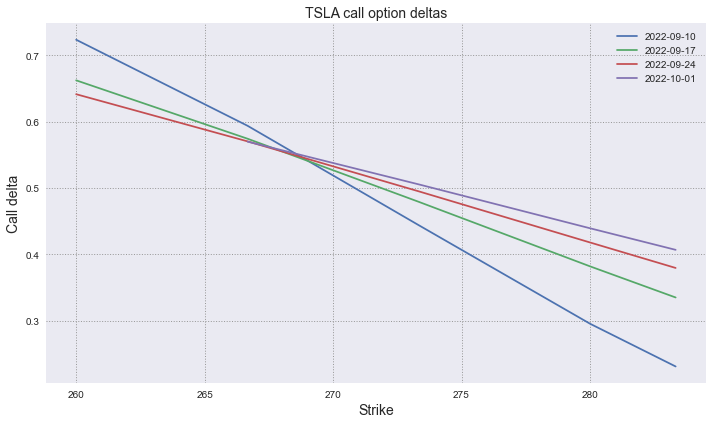

In [133]:
fig, ax = plt.subplots()
for i, call_binomial_delta in enumerate(call_binomial_deltas):
    plt.plot(
        call_options_filtered_strikes,
        np.array(call_binomial_delta),
        label=pd.to_datetime(call_options_expirations[i]).date(),
    )

ax.set_xlabel("Strike", fontsize=14)
ax.set_ylabel("Call delta", fontsize=14)

ax.set_title(f"{UNDERLYING_SYMBOL} call option deltas", fontsize=14)
ax.legend()
fig.tight_layout()
plt.show()

***
<font size=4>**Call options gammas**</font>

In [134]:
american_or_european = "A"
call_or_put = "C"
call_binomial_gammas = []
for j, expiration in enumerate(call_options_filtered_expirations):
    binomial_gamma_temp = []
    for i, strike in enumerate(call_options_filtered_strikes):
        try:
            option = call_options_filtered_by_strike_exp.loc[strike, expiration]
            binomial_gamma_temp.append(
                binomial_tree_γ(
                    underlying_price,
                    strike,
                    option["dte"],
                    treasury_yields[j],
                    option["impliedVolatility"],
                    american_or_european,
                    call_or_put,
                )
            )
        except KeyError:
            binomial_gamma_temp.append(np.NaN)
    call_binomial_gammas.append(binomial_gamma_temp)

Graph call option gammas obtained by using binomial tree:

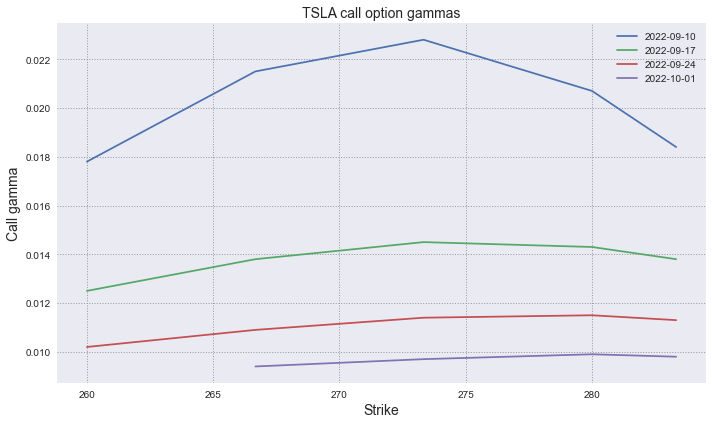

In [135]:
fig, ax = plt.subplots()
for i, call_binomial_gamma in enumerate(call_binomial_gammas):
    plt.plot(
        call_options_filtered_strikes,
        np.array(call_binomial_gamma),
        label=pd.to_datetime(call_options_expirations[i]).date(),
    )

ax.set_xlabel("Strike", fontsize=14)
ax.set_ylabel("Call gamma", fontsize=14)

ax.set_title(f"{UNDERLYING_SYMBOL} call option gammas", fontsize=14)
ax.legend()
fig.tight_layout()
plt.show()

***
# Conclusions:
***
> At the start of this exercise, we examined put-call parity for American and European options. We observed that put-call parity for the European options priced using BSM model holds, however, does not hold for American options. The feature of early exercise available to holders of American options allow for the divergence of values for these type of put and call options.

> We also do price comparison between American and European options. We find not much difference in pricing of American and European call options as it is not economically feasible for these options to be exercised prior to expiration for a non-dividend paying stock. We found American put options to be more than or at least as valuable as European put options. 

> In later part of this study, we priced European options a different strike levels with both call and put options being OTM, deep-OTM, ATM, ITM and deep-ITM. We observed the progression of various greeks for call and put options. Graphs for European and American call option greeks were created for visual inspection and analysis.